In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.base import BaseEstimator, TransformerMixin

## Prepare

In [2]:
df = pd.read_csv('./Indonesian Tweets COVID-19 Handling (2020)/csv/positive-negative-only.csv', names=['tweet', 'label'])

In [3]:
df.head()

,tweet,label
0,Yuppp Karena UTANG Pemerintah jg UTANG Bangsa ...,neg
1,Yuks.. kawal kebijakan pemerintah jangan sampa...,pos
2,Yukk sama-sama bahu membahu membantuu pemerint...,pos
3,Yuk sahabat kita samasama menjaga jarak antar ...,pos
4,Yuk sahabat kita sama sama menjaga jarak antar...,pos


## Preprocess

In [4]:
# remove blank 
df = df[df['tweet'].notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   1918 non-null   object
 1   label   1918 non-null   object
dtypes: object(2)
memory usage: 30.1+ KB


In [5]:
def regexOperation(tweet):
    # Remove Non-ascii
    res = re.sub(r'[^\x00-\x7F]+',' ', tweet)

    # Remove url
    res = re.sub(r'http[s]?\:\/\/.[a-zA-Z0-9\.\/\_?=%&#\-\+!]+',' ', res)
    res = re.sub(r'pic.twitter.com?.[a-zA-Z0-9\.\/\_?=%&#\-\+!]+',' ', res)
    # Remove mention
    res = re.sub(r'\@([\w]+)',' ', res)
    
    # Remove hashtag
    # res = re.sub(r'\#([\w]+)',' ', res)
    # Proccessing hashtag (split camel case)   
    res = re.sub(r'((?<=[a-z])[A-Z]|[A-Z](?=[a-z]))', ' \\1', res)
    #res = re.sub(r'([A-Z])(?<=[a-z]\1|[A-Za-z]\1(?=[a-z]))',' \\1', res)
    
    
    # Remove special character
    res = re.sub(r'[!$%^&*@#()_+|~=`{}\[\]%\-:";\'<>?,.\/]', ' ', res)
    # Remove number
    res = re.sub(r'[0-9]+','', res)
    # Remove consecutive alphabetic characters
    res = re.sub(r'([a-zA-Z])\1\1','\\1', res)
    # Remove consecutive whitespace
    res = re.sub(' +', ' ', res)
    # Remove trailing and leading whitespace
    res = re.sub(r'^[ ]|[ ]$','', res)
    
    # Convert to lower case
    res = res.lower()

    return res

In [6]:
# Tokenization using NLTK

def tokenize(tweet):
    return word_tokenize(tweet)


In [7]:
# Stopwords removal
stopwordFactory = StopWordRemoverFactory()

stopwords = stopwordFactory.get_stop_words()

def remove_stopwords(tweet):
    return [word for word in tweet if word not in stopwords]


In [8]:
# Stemming using Sastrawi
stemmerFactory = StemmerFactory()

stemmer = stemmerFactory.create_stemmer()

def stemming(tweet):
    return [stemmer.stem(word) for word in tweet]


In [9]:
# Apply all preprocessing step except Vectorization
def preprocess(tweet):
    tweet = regexOperation(tweet)
    tweet = tokenize(tweet)
    tweet = remove_stopwords(tweet)
    tweet = stemming(tweet)
    tweet = ' '.join(tweet)
    return tweet

df['tweet'] = df['tweet'].apply(preprocess)
df.head()

,tweet,label
0,yup utang perintah jg utang bangsa indonesia a...,neg
1,yuks kawal bijak perintah jangan salah guna ok...,pos
2,yukk sama sama bahu bahu membantuu perintah pu...,pos
3,yuk sahabat samasama jaga jarak antar manusia ...,pos
4,yuk sahabat sama sama jaga jarak antar manusia...,pos


In [10]:
# Vectorization with TF-IDF
vectorizer = TfidfVectorizer(
    analyzer='word',
    max_features=1000,
    ngram_range=(1, 1)
    )

## ML

In [11]:
# # Splitting dataset
x_train, x_test, y_train, y_test = train_test_split(df['tweet'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

In [12]:
# Encoding label
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [27]:
# K-Fold Cross Validation for Hyperparameter Tuning
kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

In [46]:
# Train SVM model
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1], 'svc__gamma': [1,0.1,0.01,0.001],'svc__kernel': ['rbf', 'poly', 'sigmoid']}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(x_train, y_train_encoded)
grid_svm.score(x_test, y_test_encoded)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


0.8679152426520849

In [47]:
print(grid_svm.best_params_)

{'svc__C': 1, 'svc__gamma': 1}


## Evaluation

In [48]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)

    cf_matrix = confusion_matrix(y, pred)
    group_names = ["TN","FP","FN","TP"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap=plt.cm.copper)

    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result


{'auc': 0.8679015721120984,
 'f1': 0.7774647887323944,
 'acc': 0.7942708333333334,
 'precision': 0.7666666666666667,
 'recall': 0.7885714285714286}

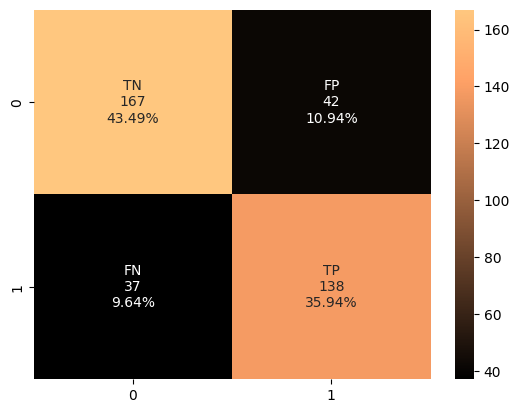

In [49]:
report_results(grid_svm.best_estimator_, x_test, y_test_encoded)

In [50]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

In [51]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, x_test, y_test_encoded)

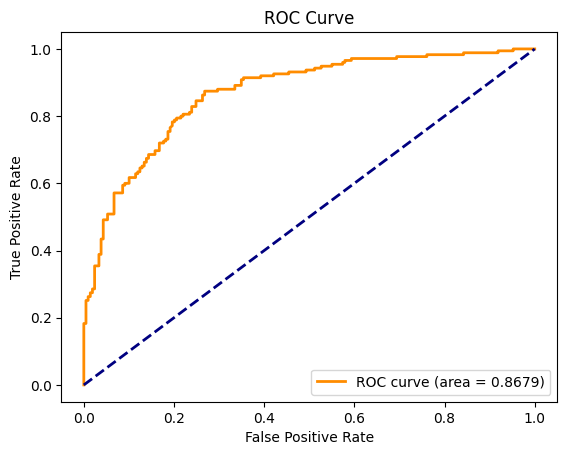

In [52]:
fpr, tpr = roc_svm
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Test on new data

In [54]:
new_tweets = [
    'seharusnya masyarakat tidak perlu khawatir dengan adanya lockdown',
    'pemerintah harusnya segera menangani covid-19 dengan baik',
    'lockdown tidak akan menyelesaikan masalah covid-19',
    'masker saja cukup untuk mencegah covid-19, pemerintah terlalu berlebihan sampai lockdown',
    'pemerintah tidak perlu lockdown, cukup dengan mengatur protokol kesehatan yang ketat',
]
le.inverse_transform(grid_svm.best_estimator_.predict([preprocess(tweet) for tweet in new_tweets]))

array(['pos', 'neg', 'neg', 'neg', 'pos'], dtype=object)